In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.datasets.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-10-14 21:47:47.382674: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 21:47:48.035838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-14 21:47:48.035912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-14 21:47:48.035919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


In [2]:
def estimate_information_analytic(h_y_estimates, noise_model, full_dataset,
                         confidence_interval, num_bootstraps=100):
    """

    Parameters
    ----------
    h_y_estimates : list or ndarray
        A list of entropy estimates h(Y). Could be a single value or multiple values (e.g., from bootstrapping).
    noise_model : NoiseModel
        A probabilistic model of the noise process p(y|x) (e.g. GaussianNoiseModel, PoissonNoiseModel).
    dataset : ndarray
    confidence_interval : float, optional
        Confidence interval for the mutual information, estimated via bootstrapping.
    num_bootstraps : int, optional
        Number of times to resample the test set to estimate the confidence interval.
    Returns
    -------
    mutual_info : float
        The mutual information in bits per pixel.
    (lower_bound, upper_bound) : tuple of floats, optional
        Lower and upper bounds of the confidence interval for the mutual information (if confidence_interval is provided).
    """
    # Make sure confidence interval is between 0 and 1
    if confidence_interval is not None:
        if confidence_interval <= 0 or confidence_interval >= 1:
            if 90 <= confidence_interval <= 100:
                warnings.warn("Confidence interval should be between 0 and 1. Dividing by 100 to convert to percentage.")
                confidence_interval /= 100
            else:
                raise ValueError("Confidence interval must be between 0 and 1")
    


    # Compute h(Y|X) using noise_model
    hy_given_x = noise_model.estimate_conditional_entropy(full_dataset)

    if confidence_interval is None:
        raise ValueError("Confidence interval must be provided to estimate mutual information")
    else:
        # Estimate conditional entropy multiple times for bootstrapping
        hy_given_xs = []
        for _ in tqdm(range(num_bootstraps), desc='Bootstrapping to compute confidence interval'):
            # Resample full dataset for conditional entropy
            bootstrap_indices = onp.random.choice(len(full_dataset), len(full_dataset), replace=True)
            bootstrap_full_dataset = full_dataset[bootstrap_indices]
            hy_given_xs.append(noise_model.estimate_conditional_entropy(bootstrap_full_dataset))

        hy_given_xs = np.array(hy_given_xs)

        # Combine h_y_estimates with hy_given_xs to compute mutual information estimates
        mutual_infos = (np.array(h_y_estimates)[None, :] - hy_given_xs[:, None]) / np.log(2)
        mutual_infos = mutual_infos.flatten()

        # Compute confidence interval
        lower_bound = np.percentile(mutual_infos, 50 * (1 - confidence_interval))
        upper_bound = np.percentile(mutual_infos, 50 * (1 + confidence_interval))
        mutual_info = np.mean(mutual_infos)
        return mutual_info, lower_bound, upper_bound


## MI vs num photons

In [3]:
from encoding_information import estimate_information
from encoding_information.models import PixelCNN, PoissonNoiseModel, FullGaussianProcess

channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 24
num_images = 5000
num_patches = 5000
photons_per_pixel = [30, 60, 120, 240, 480]
num_models_upper_bound = 5
num_bootstrapped_analytic_models = 11
confidence = .95
patch_size = 20
test_fraction = 0.1


# channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
# edge_crop = 24
# num_images = 500
# num_patches = 500
# photons_per_pixel = [20, 200]
# num_models_upper_bound = 3
# num_bootstrapped_analytic_models = 11
# confidence = .95
# patch_size = 5

if not os.path.exists('.cache'):
    os.mkdir('.cache')

mi_means_by_channel_photons = {}
mi_confidences_by_channel_photons = {}
mi_means_by_channel_photons_pixel_cnn = {}
mi_confidences_by_channel_photons_pixel_cnn = {}
mi_means_by_channel_photons_analytic = {}
mi_confidences_by_channel_photons_analytic = {}
for channel_name in tqdm(channel_names):
    mi_means_by_channel_photons[channel_name] = []
    mi_confidences_by_channel_photons[channel_name] = []
    mi_means_by_channel_photons_pixel_cnn[channel_name] = []
    mi_confidences_by_channel_photons_pixel_cnn[channel_name] = []
    mi_means_by_channel_photons_analytic[channel_name] = []
    mi_confidences_by_channel_photons_analytic[channel_name] = []

    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, median_filter=False, verbose=False, batch=1)
    for num_photons in photons_per_pixel:
        
      # cache_name = '.cache/analytic_entropy_{}_{}_samples.npz'.format(channel_name, num_photons)
      # if os.path.exists(cache_name):
      #   print('loading cached data')
      #   loaded = onp.load(cache_name)
      #   # append to the list of estimates
      #   mi_means_by_channel_photons[channel_name].append(loaded['mi_mean'])
      #   mi_confidences_by_channel_photons[channel_name].append(loaded['mi_confidence'])
      #   mi_means_by_channel_photons_pixel_cnn[channel_name].append(loaded['mi_mean_pixel_cnn'])
      #   mi_confidences_by_channel_photons_pixel_cnn[channel_name].append(loaded['mi_confidence_pixel_cnn'])
      #   mi_means_by_channel_photons_analytic[channel_name].append(loaded['mi_mean_analytic'])
      #   mi_confidences_by_channel_photons_analytic[channel_name].append(loaded['mi_confidence_analytic'])
      # else:
      patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
      noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=num_photons / np.mean(images))
      # patches *= num_photons / np.mean(images)
      # noisy_patches = add_noise(patches)

      train_patches = noisy_patches[:int(noisy_patches.shape[0] * (1 - test_fraction))]
      test_patches = noisy_patches[int(noisy_patches.shape[0] * (1 - test_fraction)):]


      models_pcnn = []
      models_gaussian = []
      for i in range(num_models_upper_bound):
        pixelcnn = PixelCNN()
        pixelcnn.fit(train_patches, verbose=False)
        models_pcnn.append(pixelcnn)

        gaussian_process = FullGaussianProcess(train_patches)
        models_gaussian.append(gaussian_process)

      
      noise_model = PoissonNoiseModel()
        
      estimate, lower, upper = estimate_information(models_pcnn, noise_model, train_patches, test_patches, confidence_interval=confidence)
      mi_means_by_channel_photons_pixel_cnn[channel_name].append(estimate)
      mi_confidences_by_channel_photons_pixel_cnn[channel_name].append((lower, upper))

      estimate, lower, upper = estimate_information(models_gaussian, noise_model, train_patches, test_patches, confidence_interval=confidence)
      mi_means_by_channel_photons[channel_name].append(estimate)
      mi_confidences_by_channel_photons[channel_name].append((lower, upper))


      # fit Gaussian to full, resampled
      analytic_entropies = []
      for i in range(num_bootstrapped_analytic_models):
        resampled_noisy_patces = noisy_patches[onp.random.choice(noisy_patches.shape[0], noisy_patches.shape[0], replace=True)]
        gaussian_process = FullGaussianProcess(resampled_noisy_patces)
        analytic_entropy = gaussian_process.compute_analytic_entropy()
        analytic_entropies.append(analytic_entropy)

      estimate, lower, upper = estimate_information_analytic(analytic_entropies, noise_model, noisy_patches, confidence_interval=confidence)

      mi_means_by_channel_photons_analytic[channel_name].append(estimate)
      mi_confidences_by_channel_photons_analytic[channel_name].append((lower, upper))


        # # save all these results to a numpy file
        # onp.savez(cache_name[:-4],
        #   mi_mean=mi_mean,
        #   mi_confidence=mi_confidence,
        #   mi_mean_pixel_cnn=mi_mean_pixel_cnn,
        #   mi_confidence_pixel_cnn=mi_confidence_pixel_cnn,
        #   mi_mean_analytic=mi_mean_analytic,
        #   mi_confidence_analytic=mi_confidence_analytic,
        #             )

    
mi_means_by_channel_photons = {channel: np.array(v) for channel, v in mi_means_by_channel_photons.items()}
mi_confidences_by_channel_photons = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons.items()}
mi_means_by_channel_photons_pixel_cnn = {channel: np.array(v) for channel, v in mi_means_by_channel_photons_pixel_cnn.items()}
mi_confidences_by_channel_photons_pixel_cnn = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons_pixel_cnn.items()}
mi_means_by_channel_photons_analytic = {channel: np.array(v) for channel, v in mi_means_by_channel_photons_analytic.items()}
mi_confidences_by_channel_photons_analytic = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons_analytic.items()}

  0%|                                                             | 0/3 [00:00<?, ?it/s]2024-10-14 21:48:41.178312: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

training:  22%|████████▌                               | 43/200 [03:26<12:35,  4.81s/it]

training:  22%|████████▊                               | 44/200 [03:31<12:29,  4.80s/it]

training:  21%|████████▍                               | 42/200 [03:32<13:20,  5.07s/it]

training:  21%|████████▍                               | 42/200 [03:21<12:36,  4.79s/it]

training:  22%|████████▌                               | 43/200 [03:27<12:37,  4.83s/it]

Evaluating NLL: 0it [00:00, ?it/s]
Evaluating NLL: 1it [00:02,  2.77s/it]
Evaluating NLL: 16it [00:05,  2.90it/s]

Evaluating NLL: 0it [00:00, ?it/s]
Evaluating NLL: 1it [00:00,  1.18it/s]
Evaluating NLL: 16it [00:01,  9.10it/s]

Evaluating NLL:

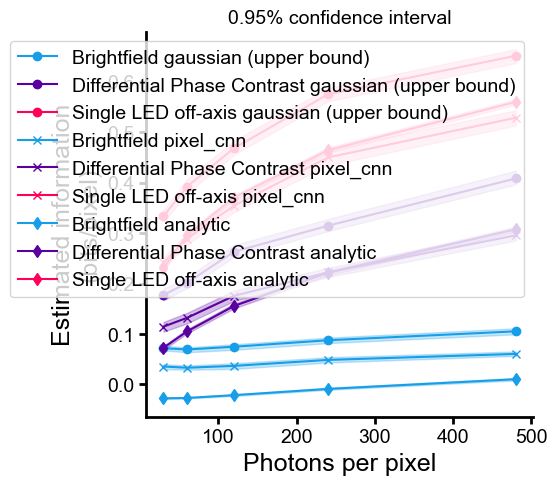

In [4]:
from cleanplots import *

colors =  get_color_cycle()
markers = ['o', 'x', 'd']
models = ['gaussian (upper bound)', 'pixel_cnn', 'analytic']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, (means, confidences) in enumerate(zip([mi_means_by_channel_photons, mi_means_by_channel_photons_pixel_cnn, mi_means_by_channel_photons_analytic], 
                              [mi_confidences_by_channel_photons, mi_confidences_by_channel_photons_pixel_cnn, mi_confidences_by_channel_photons_analytic])):
    for channel, color in zip(channel_names, colors):
        ax.plot(photons_per_pixel, means[channel], label=get_display_channel_names(channel) + ' ' + models[i],
                color=color, linestyle='-', marker=markers[i])
        ax.fill_between(photons_per_pixel, confidences[channel][:, 0], confidences[channel][:, 1], alpha=0.25, color=color)

ax.set(xlabel='Photons per pixel', ylabel='Estimated information\n(bits/pixel)')
ax.legend()
clear_spines(ax)
ax.title.set_text(f'{confidence}% confidence interval')

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/analytic_vs_nll_entropy.pdf', transparent=True)